In [1]:
import msprime, pyslim
import tskit
import json
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import itertools
import math

import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import os
import gpustat
import pandas as pd
from torch.utils.data import DataLoader, random_split, TensorDataset
from torch import nn
from torchvision.io import read_image
import torchvision.transforms as transforms

import sklearn
import sklearn.model_selection

rng = np.random.default_rng()

In [2]:
stats = gpustat.GPUStatCollection.new_query()
ids = map(lambda gpu: int(gpu.entry['index']), stats)
ratios = map(lambda gpu: float(gpu.entry['memory.used'])/float(gpu.entry['memory.total']), stats)
bestGPU = min(zip(ids, ratios), key=lambda x: x[1])[0]
os.environ['CUDA_VISIBLE_DEVICES'] = str(bestGPU)
print(stats)

GPUStatCollection(host=poppy, [
  [0] NVIDIA A100 80GB PCIe | 32°C,   0 % |     0 / 81920 MB |
  [1] NVIDIA A100 80GB PCIe | 27°C,   0 % |     0 / 81920 MB |
  [2] NVIDIA A100 80GB PCIe | 28°C,   0 % |     0 / 81920 MB |
])


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
base_folder = "."
labels = pd.read_csv(base_folder + "/labels.csv")
labels

,R0,surv_mult,rep,bias,N_avg,N_final,n,npops,nsibs
0,8.52,0.99,1,1.0,1937.047619,1602,2000,556,1511
1,8.52,0.99,1,15.5,1937.047619,1602,2050,679,1883
2,8.52,0.99,1,30.0,1937.047619,1602,2050,705,2033
3,8.52,0.99,2,1.0,2631.428571,2390,2000,406,1262
4,8.52,0.99,2,15.5,2631.428571,2390,2050,510,1520
...,...,...,...,...,...,...,...,...,...
22945,9.90,1.01,49,15.5,26395.000000,29341,2050,73,179
22946,9.90,1.01,49,30.0,26395.000000,29341,2050,75,160
22947,9.90,1.01,50,1.0,25813.714286,28081,2000,48,129
22948,9.90,1.01,50,15.5,25813.714286,28081,2050,59,168


In [5]:
class KinDataset(Dataset):
    def __init__(self, base_folder, labels_file):
        self.labels = pd.read_csv(base_folder + "/" + labels_file)
        self.base_folder = base_folder
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        row = self.labels.iloc[idx,]
        R0 = row.loc['R0']
        surv_mult = row.loc['surv_mult']
        rep = int(row.loc['rep'])
        bias = row.loc['bias']
        n = int(2000)
        spaghetti_pops_path = f'{self.base_folder}/bearded_seal_images/spaghetti_pops_{R0}_{surv_mult}_{rep}_{bias}_{n}.png'
        spaghetti_pops = read_image(spaghetti_pops_path)
        spaghetti_sibs_path = f'{self.base_folder}/bearded_seal_images/spaghetti_sibs_{R0}_{surv_mult}_{rep}_{bias}_{n}.png'
        spaghetti_sibs = read_image(spaghetti_sibs_path)
        intensity_path = f'{self.base_folder}/bearded_seal_images/sampling_intensity_{R0}_{surv_mult}_{rep}_{bias}_{n}.png'
        intensity = read_image(intensity_path)
        input_tensor = torch.cat((spaghetti_pops, spaghetti_sibs, intensity), 0).float()
        label = torch.tensor([self.labels['N_final'].iloc[idx], self.labels['N_avg'].iloc[idx]]).float()
        return input_tensor, label, surv_mult, bias
    
kin_dataset = KinDataset(".", "labels.csv")

In [17]:
print(kin_dataset[60][3])

1.0


In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=6, padding=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=6, padding=3)
        self.fc1 = nn.Linear(1000000, 1024)
        self.fc2 = nn.Linear(1024, 1)
        self.dropout = nn.Dropout(p=0.2)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten() 
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = Net()
model = model.to(device) 

In [8]:
# Load model trained on no population decline
PATH = "../model_pops_sibs.pt"
model = Net()
model.load_state_dict(torch.load(PATH))
model.eval()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(6, 6), stride=(1, 1), padding=(3, 3))
  (conv2): Conv2d(32, 64, kernel_size=(6, 6), stride=(1, 1), padding=(3, 3))
  (fc1): Linear(in_features=1000000, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

## Record bias when testing
- Random simulations have maximum sampling intensity of 8
- Bias 15.5 have max intensity 132
- Bias 30 have max intensity 255

In [27]:
test_kin, other_kin = random_split(kin_dataset, [500, len(kin_dataset)-500], generator=torch.Generator().manual_seed(42))

In [28]:
torch.cuda.synchronize()
model_cpu = model.cpu()

test_truth_N_final = np.empty(len(test_kin))
test_truth_N_avg = np.empty(len(test_kin))
test_pred = np.empty(len(test_kin))
test_surv_mult = np.empty(len(test_kin))
test_bias = np.empty(len(test_kin))

# If you add channels to the input, you need to change how the bias is calculated so that its using the correct image
with torch.no_grad():
    for i, (test_input, test_output, surv_mult, bias) in enumerate(test_kin):
        test_pred[i] = model(test_input.unsqueeze(0))[0][0]
        test_truth_N_final[i] = test_output[0]
        test_truth_N_avg[i] = test_output[1]
        test_bias[i] = bias
        test_surv_mult[i] = surv_mult

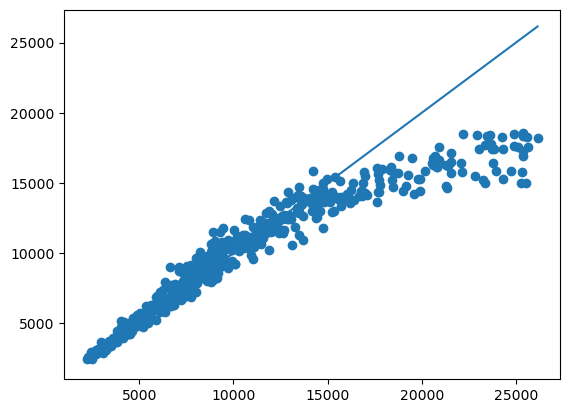

In [34]:
test_truth = test_truth_N_avg
plt.scatter(test_truth, test_pred)
plt.plot([np.min(test_truth), np.max(test_truth)], [np.min(test_truth), np.max(test_truth)])

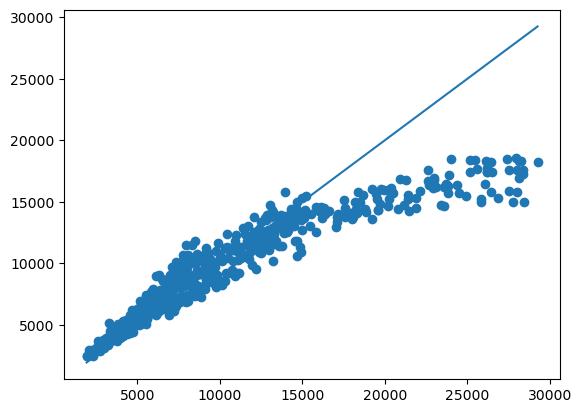

In [35]:
test_truth = test_truth_N_final
plt.scatter(test_truth, test_pred)
plt.plot([np.min(test_truth), np.max(test_truth)], [np.min(test_truth), np.max(test_truth)])

In [36]:
# Write test results to file
results = {'true_N_avg': test_truth_N_avg, 'true_N_final': test_truth_N_final, 'bearded_nn_pred': test_pred, 'bias': test_bias, 'surv_mult': test_surv_mult}
df = pd.DataFrame(data=results)
df.to_csv("../bearded_seals_nn_results/model_pops_sibs_changing size.csv", index = False)

random reps 172
medium bias reps 156
high bias reps 156


Text(0.5, 1.0, 'High bias')

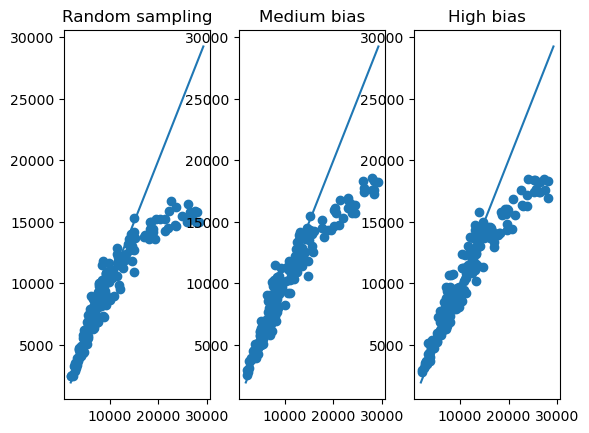

In [37]:
# Divide test data by sampling plan and plot separately
random = test_bias == 1
medium_bias = test_bias == 15.5
high_bias = test_bias == 30

print("random reps", sum(random))
print("medium bias reps", sum(medium_bias))
print("high bias reps", sum(medium_bias))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.scatter(test_truth[random], test_pred[random])
ax1.plot([np.min(test_truth), np.max(test_truth)], [np.min(test_truth), np.max(test_truth)])
ax1.set_title("Random sampling")
ax2.scatter(test_truth[medium_bias], test_pred[medium_bias])
ax2.plot([np.min(test_truth), np.max(test_truth)], [np.min(test_truth), np.max(test_truth)])
ax2.set_title("Medium bias")
ax3.scatter(test_truth[high_bias], test_pred[high_bias])
ax3.plot([np.min(test_truth), np.max(test_truth)], [np.min(test_truth), np.max(test_truth)])
ax3.set_title("High bias")
